![](https://3.bp.blogspot.com/-bwI-Pr1rNVg/WHoSXAJN_XI/AAAAAAAAYrQ/Z3VV1nvjrqATUy6WtGqJ-DgIRe0UsiOTQCLcB/s1600/Gifs%2Banimados%2BDiamante%2B1.gif)

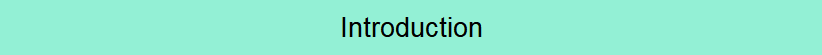

Diamonds... desired and expensive, diamonds are one of nature's most beautiful creations. It is the hardest mineral on the planet, no other mineral or substance can scratch it, on the other hand, it is very fragile, and it breaks easily.

Did you know that about 250 tons of gravel are needed to extract only one carat of diamond? And that 80% of the diamonds mined are used for industrial purposes?


Really cool facts, here in this notebook i am going to predict diamond prices using some regression algorithms, but before that, an exploratory data analysis will be done.

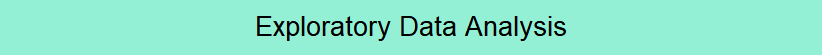

In [ ]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

SEED = 42

In [ ]:
# Loading data
df = pd.read_csv("/kaggle/input/diamonds/diamonds.csv")
df.head(8)

* **carat** - Carat weight of the diamond.
* **cut** - Describes the cut quality of the diamond (from the best to worst: Ideal, Premium, Very Good, Good and Fair).
* **color** - Color of the diamond (from the best to worst: D, E, F, G, H, I and J).
* **clarity** - A measurement of how clear the diamond is (from the best to worst: IF, VVS1, VVS2, VS1, VS2, SI1, SI2 and I1).
* **depth** - The height of a diamond, measured from the culet to the table, divided by the average girdle diameter (%).
* **table** - The width of a diamond table expressed as a percentage of the average diameter (%).
* **x** - Diamond length (mm).
* **y** - Diamond width (mm).
* **z** - Diamond depth (mm).
* **price** - Diamond price.

In [ ]:
# Getting some information about the data
df.info()

# <font size="4">Missing Values</font>

As we can see from <code>df.info()</code>, there are no missing values.

In [ ]:
if df.isnull().sum().any() == False:
    print("there are no missing values")
else:
    print("there are something wrong here")

# <font size="4">Duplicate Rows</font>

Let's check for duplicate rows, but first we need to delete the "Unnamed: 0" column, since it is useless for us and has a diffent value for each row, in other words, if we do not drop this column, the number of duplicate lines will always be zero.

In [ ]:
# Dropping "Unnamed: 0" column
df = df.drop(["Unnamed: 0"], axis = 1)

# Checking for duplicate rows
print("number of duplicate rows: ", df.duplicated().sum())

In [ ]:
# Dropping them
df = df.drop_duplicates().reset_index(drop = True)

# <font size="4">Data Describe</font>

In [ ]:
# Numerical data
df.describe().T

In [ ]:
# Categorical data
df.describe(include = "O").T

After use <code>df.describe().T</code>, we could see that the minimun value of **x**, **y** and **z** are equal to zero. Let's take a look at them.

In [ ]:
format_dict = {"carat" : "{:.2f}", "depth" : "{:.1f}", "table" : "{:.1f}", "x" : "{:.2f}", "y" : "{:.2f}", "z" : "{:.2f}"}
df_zero = df.loc[(df["x"] == 0) | (df["y"] == 0) | (df["z"] == 0)]
df_zero.style.apply(lambda x: ["background: yellow" if n == 0 else "" for n in x], axis = 1).format(format_dict)

We know that this values must be greater than zero, but for some reason they are not. So let's treat them as missing values.

In [ ]:
# Transforming them into NaN values
df.loc[df["x"] == 0, "x"] = np.nan 
df.loc[df["y"] == 0, "y"] = np.nan 
df.loc[df["z"] == 0, "z"] = np.nan 

# Seeing the number of the new missing values
df[["x", "y", "z"]].isnull().sum()

Now, we have three columns with missing values. Let's see the strongest correlations for each one of them.

In [ ]:
def get_corr(col):
    return df.corr().unstack()[col].sort_values(ascending = False)    

In [ ]:
print("x correlations\n\n{0}\n\n{3}\n\ny correlations\n\n{1}\n\n{3}\n\nz correlations\n\n{2}".format(get_corr("x"), get_corr("y"), get_corr("z"), 25*"-"))

* **x** strongest correlation is with **carat**
* **y** strongest correlation is with **x**
* **z** strongest correlation is with **x**

Since **carat** has no missing values and has a strong correlation with **x**, **y** and **z**, let's assume that the strongest correlation of all dimensions is with **carat**, because in some cases more than one dimension value is misising at the same row and we are going to use the median of this correlation to fill them.

In [ ]:
def fill_nan_values(col):
    carat = df.groupby(["carat"])[col].median()
    index_list = list(df.loc[df[col].isnull() == True].sort_values(by = "carat", ascending = False).index)
    for i in index_list:
        carat_value = df.loc[i, "carat"]
        new_value = carat[carat_value]
        df.loc[i, col] = new_value
        print("carat: {0} / median {1} value: {2}".format(carat_value, col, new_value))
    return df.iloc[index_list].style.applymap(lambda x: "background-color: limegreen", subset = col).format(format_dict)

I put the values in descending order, so we can better visualize this correlation.

In [ ]:
# Fixing "x" column
fill_nan_values("x")

In [ ]:
# Fixing "y" column
fill_nan_values("y")

In [ ]:
# Fixing "z" column
fill_nan_values("z")

# <font size="4">Outliers</font>

There are a lot of methods to find outlier values, but here we are going to use the simplest one: manually visualizing them. To this, we need to plot graphs showing the relation between all numerical features and the target (price).


In [ ]:
def highlight_outliers(outliers, col):
    outliers_index = outliers.index
    i = pd.IndexSlice[outliers_index, col]
    return outliers.style.applymap(lambda x: "background-color: red", subset = i).format(format_dict)

In [ ]:
sns.set_style("whitegrid")
c = "darkturquoise"

plt.figure(figsize = (12, 18))
plt.subplot(3, 2, 1)
plt.title("price X carat")
sns.regplot(data = df, x = "price", y = "carat", color = c, line_kws = {"color" : "black"})
plt.subplot(3, 2, 2)
plt.title("price X depth")
sns.regplot(data = df, x = "price", y = "depth", color = c, line_kws = {"color" : "black"})
plt.subplot(3, 2, 3)
plt.title("price X table")
sns.regplot(data = df, x = "price", y = "table", color = c, line_kws = {"color" : "black"})
plt.subplot(3, 2, 4)
plt.title("price X x")
sns.regplot(data = df, x = "price", y = "x", color = c, line_kws = {"color" : "black"})
plt.subplot(3, 2, 5)
plt.title("price X y")
sns.regplot(data = df, x = "price", y = "y", color = c, line_kws = {"color" : "black"})
plt.subplot(3, 2, 6)
plt.title("price X z")
sns.regplot(data = df, x = "price", y = "z", color = c, line_kws = {"color" : "black"})
plt.show()

By looking at this graphs, we can see three values that are really far from others (notice the thickness difference between the last two graphs and the others). Let's take a look at them.

* <font size="3">price X y</font>

In [ ]:
df_outliers = df.loc[df["y"] > 30].copy()
highlight_outliers(df_outliers, "y")

* <font size="3">price X z</font>

In [ ]:
df_outliers = df.loc[df["z"] > 30].copy()
highlight_outliers(df_outliers, "z")

This values are true outliers, let's treat them as missing values and do the same thing we did before.

In [ ]:
# Transforming them into NaN values
df.loc[df["y"] > 30, "y"] = np.nan
df.loc[df["z"] > 30, "z"] = np.nan

In [ ]:
# Fixing "y" column
fill_nan_values("y")

In [ ]:
# Fixing "z" column
fill_nan_values("z")

Now that we are free of this true outliers, let's analyze the possible outliers.

* <font size="3">price X depth</font>

In [ ]:
df_outliers = df.loc[(df["depth"] > 75) | (df["depth"] < 45)].copy()
highlight_outliers(df_outliers, "depth")

Well, even if this values are considerably distants from others they are not absurd values (e.g. 550%). Let's leave them as they are.

* <font size="3">price X table</font>

In [ ]:
df_outliers = df.loc[(df["table"] > 90) | (df["depth"] < 45)].copy()
highlight_outliers(df_outliers, "table")

Same thing as before.

* <font size="3">price X z</font>

In [ ]:
df_outliers = df.loc[df["z"] < 2].copy()
highlight_outliers(df_outliers, "z")

For some reason this **z** values are equal to the **carat**.

In [ ]:
df.loc[df["carat"] == df["z"], ["carat", "z"]]

This can not just be a coincidence, as only this three has this equal values (**carat** = **z**), so let's fix them, repeating the process.

In [ ]:
# Transforming them into NaN values
df.loc[df["z"] < 2, "z"] = np.nan

In [ ]:
fill_nan_values("z")

# <font size="4">Data Visualization</font>

In [ ]:
cut_palette = ["darkturquoise", "lightskyblue", "paleturquoise", "lightcyan", "azure"]
color_palette = ["cadetblue", "deepskyblue", "darkturquoise", "lightskyblue", "paleturquoise", "lightcyan", "azure"]
clarity_palette = ["cadetblue", "deepskyblue", "darkturquoise", "lightskyblue", "paleturquoise", "lightcyan", "azure", "ghostwhite"]

df["cut"] = pd.Categorical(df["cut"], categories = ["Ideal", "Premium", "Very Good", "Good", "Fair"], ordered = True)
df["color"] = pd.Categorical(df["color"], categories = ["D", "E", "F", "G", "H", "I", "J"], ordered = True)
df["clarity"] = pd.Categorical(df["clarity"], categories = ["IF", "VVS1", "VVS2", "VS1", "VS2", "SI1", "SI2", "I1"], ordered = True)

In [ ]:
df_cut = df["cut"].value_counts()

plt.figure(figsize = (7,7))
plt.pie(data = df_cut, x = df_cut.values, labels = df_cut.index, autopct = "%.2f%%", pctdistance = 0.8, colors = cut_palette )
circle = plt.Circle(xy = (0, 0), radius = 0.5, facecolor = 'white')
plt.gca().add_artist(circle)
plt.title("% of each Diamond Cut Quality", size = 16)
plt.show()

Remembering the order: Ideal > Premium > Very Good > Good > Fair


In [ ]:
position = 0
for cut in df_cut:
    print("{0} quality cuts: {1}".format(df_cut.index[position], df_cut.values[position]))
    position += 1

As we can see, there are a lot more high quality cut diamonds. Now let's see how this affects the price.

In [ ]:
plt.figure(figsize = (9, 6))
sns.barplot(data = df, x = "cut", y = "price", color = c)
plt.title("Relation between Cut and Price", size = 16)
plt.show()

Well... this was unexpected, why the mean price of diamonds with ideal cuts are lower than all other diamonds with less quality cut?

Let's look which feature most impact on price.

In [ ]:
get_corr("price")

... and it is the carat.

So, if the carat is the most important thing, when we are looking for the price... Than, diamonds with ideal cuts, should have lower carat value.

In [ ]:
df.groupby(["cut"])["carat"].mean()

Here it is, that is why the mean price of ideal cut diamonds is the lowest one.

In [ ]:
df_color = df["color"].value_counts()

plt.figure(figsize = (7,7))
plt.pie(data = df_color, x = df_color.values, labels = df_color.index, autopct = "%.2f%%", pctdistance = 0.8, startangle = 40, colors = color_palette)
circle = plt.Circle(xy = (0, 0), radius = 0.5, facecolor = 'white')
plt.gca().add_artist(circle)
plt.title("% of each Diamond Color", size = 16)
plt.show()

Remembering the order: D > E > F > G > H > I > J

In [ ]:
position = 0
for color in df_color:
    print("{0} color diamonds: {1}".format(df_color.index[position], df_color.values[position]))
    position += 1

In [ ]:
plt.figure(figsize = (9, 6))
sns.barplot(data = df, x = "color", y = "price", color = c)
plt.title("Relation between Diamond Color and Price", size = 16)
plt.show()

Again, the mean price of diamonds with better colors are lower than all other diamonds with worst colors.

In [ ]:
df.groupby(["color"])["carat"].mean()

And the reason is the same as the cut.

In [ ]:
df_clarity = df["clarity"].value_counts()

plt.figure(figsize = (7,7))
plt.pie(data = df_clarity, x = df_clarity.values, labels = df_clarity.index, autopct = "%.2f%%", pctdistance = 0.8, colors = clarity_palette)
circle = plt.Circle(xy = (0, 0), radius = 0.5, facecolor = 'white')
plt.gca().add_artist(circle)
plt.title("% of each Diamond Clarity", size = 16)
plt.show()

Remembering the order: IF > VVS1 > VVS2 > VS1 > VS2 > SI1 > SI2 > I1

In [ ]:
position = 0
for color in df_clarity:
    print("{0} clarity diamonds: {1}".format(df_clarity.index[position], df_clarity.values[position]))
    position += 1

In [ ]:
plt.figure(figsize = (9, 6))
sns.barplot(data = df, x = "clarity", y = "price", color = c)
plt.title("Relation between Diamond Clarity and Price", size = 16)
plt.show()

And again...

In [ ]:
df.groupby(["clarity"])["carat"].mean()

And the reason is the same.

# <font size="4">Data Preparation</font>

In [ ]:
# Splitting the data into features and target
X = df.drop(["price"], axis = 1).copy()
y = df["price"].copy()

Some algorithms answers better with dummie variables, others with correctly ordered label encoder, so let's create two different ones.

In [ ]:
# Dummy variables
X_dummies = X.copy()
X_dummies = pd.get_dummies(data = X_dummies, columns = ["clarity", "color", "cut"], prefix = ["clarity", "color", "cut"], drop_first = True).copy()

# Scaling the data
ss = StandardScaler()
X_dummies = ss.fit_transform(X_dummies)

# Label encoder
X_encoder = X.copy()
X_encoder["cut"] = X_encoder["cut"].replace({"Ideal": 1, "Premium": 2, "Very Good": 3, "Good": 4, "Fair": 5}).copy()
X_encoder["color"] = X_encoder["color"].replace({"D": 7, "E": 6, "F": 5, "G": 4, "H": 3, "I": 2, "J": 1}).copy()
X_encoder["clarity"] = X_encoder["clarity"].replace({"IF" : 8, "VVS1" : 7, "VVS2" : 6, "VS1" : 5, "VS2" : 4, "SI1" : 3, "SI2" : 2, "I1" : 1}).copy()

In [ ]:
# K-folds for cross-validation
kf = KFold(n_splits = 10, random_state = SEED, shuffle = True)

# Evaluating the cross-validation
scoring = ["r2", "neg_mean_absolute_error", "neg_mean_squared_error"]

In [ ]:
model_scores = {"train" : [],
                "test" : [],
                "mae" : [],
                "mse" : [],
                "rmse" : []}

def get_results(clf, features):
    scores = cross_validate(clf, features, y, cv = kf, scoring = scoring, return_train_score = True)
    train_score = scores["train_r2"].mean()
    model_scores["train"].append(train_score)
    test_score = scores["test_r2"].mean()
    model_scores["test"].append(test_score)
    mae = np.absolute(scores["test_neg_mean_absolute_error"]).mean()
    model_scores["mae"].append(mae)
    mse = np.absolute(scores["test_neg_mean_squared_error"]).mean()
    model_scores["mse"].append(mse)
    rmse = np.sqrt(mse)
    model_scores["rmse"].append(rmse)
    print("train score: {0:.4f}\nR2 score: {1:.4f}\nMAE: {2:.2f}\nMSE: {3:.2f}\nRMSE: {4:.2f}".format(train_score, test_score, mae, mse, rmse))

Note that all values are the mean of all cross-validation runs.

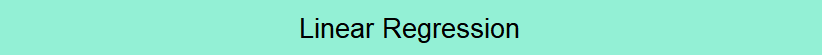

In [ ]:
lr = LinearRegression()
get_results(lr, X_dummies)

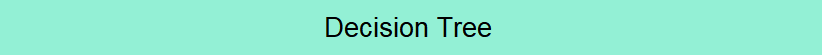

In [ ]:
dtr = DecisionTreeRegressor(max_depth = 8, random_state = SEED)
get_results(dtr, X_encoder)

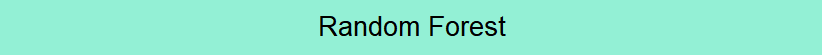

In [ ]:
rfr = RandomForestRegressor(max_depth = 8, n_estimators = 40, random_state = SEED)
get_results(rfr, X_encoder)

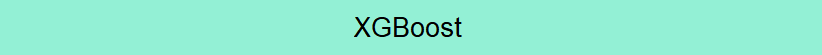

In [ ]:
xgbr = XGBRegressor(learning_rate = 0.1, n_estimators = 200, random_state = SEED)
get_results(xgbr, X_encoder)

In [ ]:
print("train score\n")
print("Linear Regression: {0:.4f}\nDecision Tree: {1:.4f}\nRandom Forest: {2:.4f}\nXGBoost: {3:.4f}".format(model_scores["train"][0],model_scores["train"][1], model_scores["train"][2], model_scores["train"][3]))
print("\nR2 score\n")
print("Linear Regression: {0:.4f}\nDecision Tree: {1:.4f}\nRandom Forest: {2:.4f}\nXGBoost: {3:.4f}".format(model_scores["test"][0],model_scores["test"][1], model_scores["test"][2], model_scores["test"][3]))
print("\nMAE\n")
print("Linear Regression: {0:.2f}\nDecision Tree: {1:.2f}\nRandom Forest: {2:.2f}\nXGBoost: {3:.2f}".format(model_scores["mae"][0],model_scores["mae"][1], model_scores["mae"][2], model_scores["mae"][3]))
print("\nMSE\n")
print("Linear Regression: {0:.2f}\nDecision Tree: {1:.2f}\nRandom Forest: {2:.2f}\nXGBoost: {3:.2f}".format(model_scores["mse"][0],model_scores["mse"][1], model_scores["mse"][2], model_scores["mse"][3]))
print("\nRMSE\n")
print("Linear Regression: {0:.2f}\nDecision Tree: {1:.2f}\nRandom Forest: {2:.2f}\nXGBoost: {3:.2f}".format(model_scores["rmse"][0],model_scores["rmse"][1], model_scores["rmse"][2], model_scores["rmse"][3]))

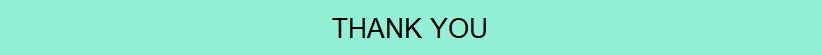